# Lego Parts in Sets - Roles Played

Requirements to run as-is:
* Google Colab and Google Drive
* Drive folder `/lego`
* Folder `/lego` contains Rebrickable [downloads](https://rebrickable.com/downloads/)
* Folder `/lego` contains a Rebrickable [API](https://rebrickable.com/api/v3/docs/) Key in the file `rbl`



# Get Data

## Google Drive

In [1]:
UPLOAD_FOLDER = 'My Drive/lego/'
CACHE_FOLDER = 'cache/'

GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CACHE_DIR = RAW_ROOT + CACHE_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_df(fname):
  return pd.read_csv(RAW_ROOT + fname)

# Rebrickable downloads
parts_df = get_df('parts.csv').set_index('part_num')
sets_df = get_df('sets.csv').set_index('set_num')
inventories_df = get_df('inventories.csv').set_index('id')
inventory_parts_df = get_df('inventory_parts.csv')
colors_df = get_df('colors.csv').set_index('id')
minifigs_df = get_df('minifigs.csv').set_index('fig_num')

## Rebrickable API & Drive Cache

In [3]:
import requests

RBL_HOST = 'https://rebrickable.com'
RBL_ROOT = '/api/v3/lego/'
RBL_PRE = RBL_HOST + RBL_ROOT

key_file = open(RAW_ROOT + 'rbl', 'r')
rbl_api_key = key_file.readlines()[0].strip()
auth_value = 'key ' + rbl_api_key
RBL_HDR = {'Authorization': auth_value }

def get_rbl_uri(uri):
  return requests.get(uri, headers=RBL_HDR).json()

def get_part_details(part_num):
  return requests.get(RBL_PRE + f'parts/{part_num}', headers=RBL_HDR).json()

def get_part_list_details(part_nums):
  part_nums_param_val = ','.join([str(p) for p in part_nums])
  other_params = '&inc_part_details=1&page_size=1000'
  uri = RBL_PRE + f'parts/?part_nums={part_nums_param_val}' + other_params
  return requests.get(uri, headers=RBL_HDR).json()

In [4]:
import glob
import json
import time

def write_part_results(results, page_num):
  Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
  results_file_name = CACHE_DIR + f'results_page_{page_num:03d}.json'
  with open(results_file_name, 'w') as outfile:
    json.dump(results, outfile)

def cache_all_parts(max_pages=100):
  page_index = 0
  page_response = get_part_list_details([])
  while page_response['next'] is not None and page_index < max_pages:
    print(f'caching results page {page_index}')
    write_part_results(page_response['results'], page_index)
    page_index = page_index + 1
    # be nice to Rebrickable API
    time.sleep(10)
    page_response = get_rbl_uri(page_response['next'])

cache_exists = len(glob.glob(CACHE_DIR + '*.json')) > 0
if not cache_exists:
  cache_all_parts()
else:
  print('cache exists')

cache exists


In [5]:
def build_cache_index():
  dir_list = sorted(glob.glob(CACHE_DIR + '*.json'))
  json_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      json_cache = json_cache + data
  return {p['part_num'] : p for p in json_cache}

# Set Up Data Structures

In [6]:
jcpn = build_cache_index()

In [7]:
sets_parts_df = pd.merge(inventory_parts_df,
                         inventories_df,
                         how='left',
                         left_on='inventory_id',
                         right_index=True)[['set_num',
                                            'part_num',
                                            'quantity',
                                            'color_id',
                                            'is_spare']]
sets_parts_df.head()

,set_num,part_num,quantity,color_id,is_spare
0,7922-1,48379c01,1,72,f
1,7922-1,48395,1,7,f
2,7922-1,stickerupn0077,1,9999,f
3,7922-1,upn0342,1,0,f
4,7922-1,upn0350,1,25,f


In [8]:
spq = sets_parts_df.groupby(['set_num', 'part_num']).sum()['quantity']
spq_sets = spq.index.levels[0]
spq.head()

set_num  part_num
001-1    132a        4
         3020        4
         3062c       1
         3404bc01    4
         36          4
Name: quantity, dtype: int64

In [9]:
psq = sets_parts_df.groupby(['part_num', 'set_num']).sum()['quantity']
psq_parts = psq.index.levels[0]
psq.head()

part_num  set_num
003381    663-1      1
003383    618-1      1
          628-2      1
003402    310-3      1
          311-1      1
Name: quantity, dtype: int64

# Hero Parts with TF-IDF

In [10]:
corpus_pbs = [' '.join([' '.join([p] * spq[(s, p)]) for p in spq[s].index]) for s in spq_sets]
corpus_pbs[:3]

['132a 132a 132a 132a 3020 3020 3020 3020 3062c 3404bc01 3404bc01 3404bc01 3404bc01 36 36 36 36 7039 7039 7039 7039 7039 7039 7049b 7049b 7049b 7049b 715 715 715 715 741 741 741 741 742 742 742 742 743 744 744 744',
 '3962a 3962a',
 '3962a 3962a']

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse

vectorizer_pbs = TfidfVectorizer()
corpus_pbs_t = vectorizer_pbs.fit_transform(corpus_pbs)

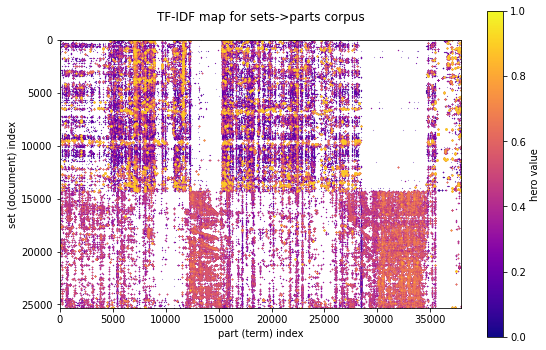

In [12]:
import matplotlib as mpl

fig = plt.figure(figsize=(9,6))
cmap = plt.get_cmap('plasma')
for lvl in np.linspace(0, 1, 10):
  plt.spy(corpus_pbs_t > lvl, color=cmap(lvl), markersize=lvl, origin='lower')

cbar_norm = mpl.colors.Normalize(vmin=0, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=cbar_norm, cmap=cmap), label='hero value')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel('part (term) index')
plt.ylabel('set (document) index')
plt.title('TF-IDF map for sets->parts corpus')
plt.show()

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

query_pbs = '2431 2412b 3023'
query_pbs_t = vectorizer_pbs.transform([query_pbs])
cossim_pbs = cosine_similarity(query_pbs_t, corpus_pbs_t).flatten()

top_result = spq_sets[np.argmax(cossim_pbs)]
print(sets_df.loc[top_result])

name         Marina Bay Sands
year                     2014
theme_id                  252
num_parts                 602
Name: 21021-1, dtype: object


In [14]:
corpus_sbp = [' '.join([' '.join([s] * psq[(p, s)]) for s in psq[p].index]) for p in psq_parts]
corpus_sbp[:3]

['663-1', '618-1 628-2', '310-3 311-1 312-3']

In [15]:
vectorizer_sbp = TfidfVectorizer()
corpus_sbp_t = vectorizer_sbp.fit_transform(corpus_sbp)

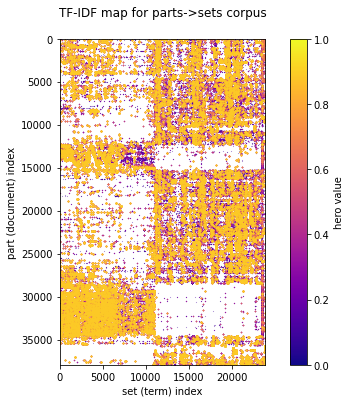

In [16]:
fig = plt.figure(figsize=(9,6))
cmap = plt.get_cmap('plasma')
for lvl in np.linspace(0, 1, 10):
  plt.spy(corpus_sbp_t > lvl, color=cmap(lvl), markersize=lvl, origin='lower')

cbar_norm = mpl.colors.Normalize(vmin=0, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=cbar_norm, cmap=cmap), label='hero value')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel('set (term) index')
plt.ylabel('part (document) index')
plt.title('TF-IDF map for parts->sets corpus')
plt.show()

In [17]:
query_sbp = '60012-1'
query_sbp_t = vectorizer_sbp.transform([query_sbp])
cossim_sbp = cosine_similarity(query_sbp_t, corpus_sbp_t).flatten()

top_results = psq_parts[np.argsort(cossim_sbp)[::-1]]
top_results[:10]

Index(['13611', '56890', '14520', '30086', '10190', '30090', '52036', '98282',
       '57783', '92409'],
      dtype='object', name='part_num')

In [18]:
from PIL import Image

def transparent_part_image(part_num, content_alpha=255):
  img = Image.new("RGBA",(10, 10), (0,0,0,0))
  url = jcpn[part_num]['part_img_url']
  if url is not None:
    img_in = Image.open(requests.get(url, stream=True).raw)
    x = np.asarray(img_in.convert('RGBA')).copy()
    x[:, :, 3] = (content_alpha * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    img = Image.fromarray(x)
  return img

In [19]:
def short_name(name, limit=18):
  return name[:(limit - 2) // 2] + ".." + name[-(limit - 2) // 2:]

def part_gallery(part_nums, title='Part gallery', columns=5, row_limit=2):
  rows_all = len(part_nums) // columns
  rows_all = rows_all + (1 if len(part_nums) % columns != 0 else 0)
  rows = min(row_limit, rows_all)

  fig, ax = plt.subplots(rows, columns)
  fig.set_figheight(3 * rows)
  fig.set_figwidth(3 * columns)

  for i in range(rows):
    ax_obj = ax[i] if rows > 1 else ax
    for j in range(columns):
      ax_obj[j].axis('off')

      n = i * columns + j
      if n >= len(part_nums):
        continue
      
      pn = part_nums[n]
      try:
        details = jcpn[pn]
        ax_obj[j].set_title(f'{short_name(details["name"])}\n #{pn}, rank {n + 1}')
      except KeyError:
        ax_obj[j].set_title(f'#{pn}, rank {n + 1}')
        continue
      
      url = details['part_img_url']
      if url is not None:
        ax_obj[j].imshow(Image.open(requests.get(url, stream=True).raw))
      
  fig.suptitle(title)
  plt.show()

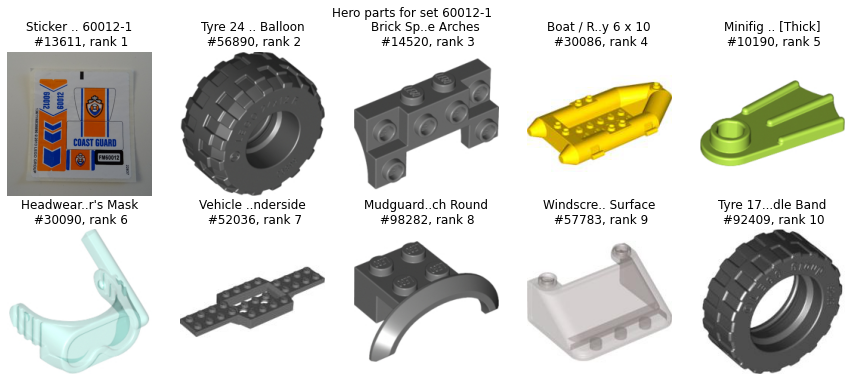

In [20]:
part_gallery(top_results[:10], title=f'Hero parts for set {query_sbp}')

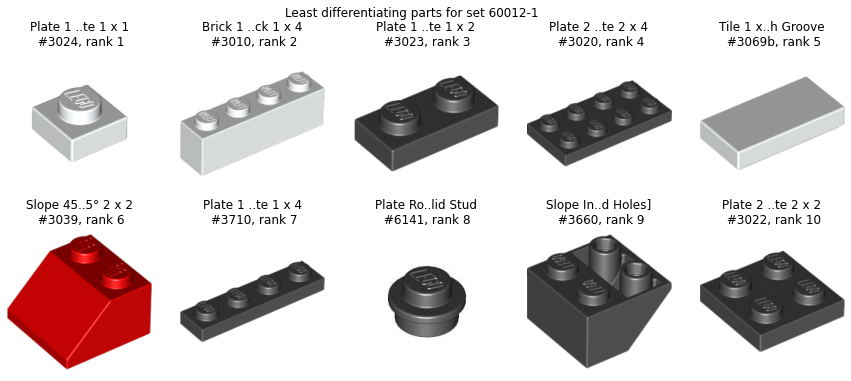

In [21]:
len_results = len(np.argwhere(cossim_sbp != 0))
bottom_results = top_results[len_results-10:len_results:]
part_gallery(bottom_results[::-1], title=f'Least differentiating parts for set {query_sbp}')